# Testing attacks against RobustBench models

In this tutorial, we will show how to correctly import [RobustBench](https://github.com/RobustBench/robustbench) models inside SecML, and how to craft adversarial evasion attacks against them using SecML.

<div class="alert alert-warning">

**Warning**

Requires installation of the `pytorch` extra dependency.
See [extra components](../index.rst#extra-components) for more information.

</div>

We start by installing the models offered by RobustBench, a repository of pre-trained adversarially robust models, written in PyTorch.
All the models are trained on CIFAR-10.
To install the library, just open a terminal and execute the following command:

```bash
pip install git+https://github.com/RobustBench/robustbench
```

After the installation, we can import the model we like among the one offered by the library ([click here](https://github.com/RobustBench/robustbench/tree/master/model_info) for the complete list):

In [16]:
from robustbench.utils import load_model
model = load_model(model_name='Carmon2019Unlabeled', norm='Linf')

This command will create a `models` directory in the current working directory, where it will download the desired model, specified by the `model_name` parameter.
Since it is a PyTorch model, we can just load one sample from CIFAR-10 to test it.

Again, the dataset will be downloaded inside a `data` directory in our current working directory.

In [23]:
from robustbench.data import load_cifar10

X, Y = load_cifar10(n_examples=10)
y_pred = model(X[:9])
print(X.shape)
print(f"Predicted classes: {y_pred.argmax(axis=1).tolist()}")
print(f"Real classes: {Y[:9].tolist()}")

Files already downloaded and verified
torch.Size([10, 3, 32, 32])
Predicted classes: [3, 8, 8, 0, 6, 6, 1, 6, 3]
Real classes: [3, 8, 8, 0, 6, 6, 1, 6, 3]


# Load RobustBench models inside SecML

We can now import the pre-trained robust model inside SecML. Since these models are all coded in PyTorch, we just need to use the PyTorch wrapper of SecML.

In order to do this, we need to express the `input_shape` of the data, and feed the classifier with the flatten version of the array (under the hood, the framework will reconstruct the original shape):

In [45]:
from secml.ml.classifiers.pytorch.c_classifier_pytorch import CClassifierPyTorch

secml_model = CClassifierPyTorch(model, input_shape=(3,32,32), pretrained=True)
x = X[0].flatten()
y_pred = secml_model.predict(x)
print(f"Predicted class: {y_pred.item()}")


Predicted class: 3


# Computing evasion attacks

Now that we have imported the model inside SecML, we can compute attacks against it.
We will use the iterative Projected Gradient Descent (PGD) attack, with `l2` perturbation.

In [50]:
from secml.adv.attacks.evasion import CAttackEvasionPGD
from secml.data import CDataset

noise_type = 'l2'   # Type of perturbation 'l1' or 'l2'
dmax = 0.5          # Maximum perturbation
lb, ub = 0, 1       # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None     # None if `error-generic` or a class label for `error-specific`

x0, y0 = X[0], Y[0]

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.4, 
    'max_iter': 100, 
    'eps': 1e-3
}

pgd_ls_attack = CAttackEvasionPGD(
    classifier=secml_model,
	double_init_ds=CDataset(X[0].flatten(), Y[0]),
    distance=noise_type, 
    dmax=dmax, 
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

y_pred_pgd, _, adv_ds_pgd, _ = pgd_ls_attack.run(x0.flatten(), y0)
print(f"Real class: {y0}")
print(f"Predicted class after the attack: {y_pred_pgd.item()}")

Real class: 3
Predicted class after the attack: 5


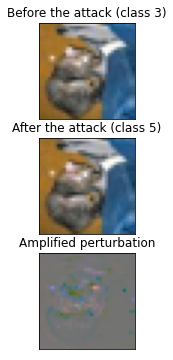

In [54]:
from secml.figure import CFigure
%matplotlib inline

img_normal = x0.transpose(0,2)
img_adv = adv_ds_pgd.X[0,:].tondarray().reshape((3,32,32)).transpose(2,1,0)

diff_img = img_normal - img_adv
diff_img -= diff_img.min()
diff_img /= diff_img.max()

fig = CFigure()
fig.subplot(3,1,1)
fig.sp.imshow(img_normal)
fig.sp.title(f'Before the attack (class {y0})')
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(3,1,2)
fig.sp.imshow(img_adv)
fig.sp.title(f'After the attack (class {y_pred_pgd.item()})')
fig.sp.xticks([])
fig.sp.yticks([])


fig.subplot(3,1,3)
fig.sp.imshow(diff_img)
fig.sp.title(f'Amplified perturbation')
fig.sp.xticks([])
fig.sp.yticks([])

fig.show()